In [1]:
from utils.normalize import HandcraftedFeaturePreprocessor

from sklearn.metrics import auc
from sklearn.svm import OneClassSVM

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pickle
import os, json

In [2]:
#preprocess

def sample_outliers(data, outlier):
    outlier_proportion = data[data.classALeRCE==outlier].shape[0] / data.shape[0]
    
    if outlier_proportion > 0.1:
        #Number of samples to remove.
        n_rm = round(data[data.classALeRCE==outlier].shape[0] - data.shape[0] * 0.1)

        df_subset = data[data.classALeRCE==outlier].sample(n_rm)
        data = data.drop(df_subset.index)
    else:
        #Number of samples to remove.
        n_rm  = round((data.shape[0] * 0.1 - data[data.classALeRCE==outlier].shape[0]) / 0.1)

        df_subset = data[data.classALeRCE!=outlier].sample(n_rm)
        data = data.drop(df_subset.index)
    return data


def get_data(hierClass, outlier):
    train = pd.read_pickle('../data/train_data_filtered.pkl')
    test = pd.read_pickle('../data/test_data_filtered.pkl')
    feature_list = pd.read_pickle('../data_raw/features_RF_model.pkl')

    train = train[train.hierClass==hierClass]
    test = test[test.hierClass==hierClass]

    #Remove the outlier from training set and append it to the test set.
    test = pd.concat([test, train[train.classALeRCE==outlier]], sort=False)
    test = sample_outliers(test, outlier)
    train = train[train.classALeRCE!=outlier]

    feature_preprocessor = HandcraftedFeaturePreprocessor()
    train = feature_preprocessor.preprocess(train[feature_list]).values
    test_features = feature_preprocessor.preprocess(test[feature_list]).values

    test_labels = np.where((test['classALeRCE']!= outlier), 0, test['classALeRCE'])
    test_labels = np.where(test['classALeRCE']==outlier, 1, test_labels)
    test_labels = test_labels.reshape(-1,).astype('int8')
    return train, test_features, test_labels

In [3]:
#utils 
def save_metrics(metrics, root_dir, mode='val'):
    """save all the metrics."""
    mt_dir = os.path.join(root_dir, 'metrics_{}.json'.format(mode))
    with open(mt_dir, 'w') as mt:
        json.dump(metrics, mt)

def plot_histogram(in_scores, out_scores, directory):
    plt.hist(in_scores, color='k', alpha=0.3, density=True, label='Inlier')
    plt.hist(out_scores, color='b', alpha=0.3, density=True, label='Outlier')
    plt.title('Inliers vs Outliers (OCSVM)')
    plt.legend()
    plt.savefig('{}/plots/histogram.png'.format(directory))
    plt.close()
    
def compute_metrics(scores, labels, plot_hist=True, directory=None):
    """
    Computing the Area under the curve ROC and PR.
    """
    in_scores = scores[labels==0]
    out_scores = scores[labels==1]

    auroc, aupr = compute_roc_pr(in_scores, out_scores)
    metrics = {'AU ROC': auroc,
               'AU PR': aupr,
               }
    if plot_hist:
        plot_histogram(in_scores, out_scores, directory)
    return metrics

def compute_roc_pr(inliers_scores, outlier_scores):
    auroc_score = auroc(inliers_scores, outlier_scores)
    aupr_score = aupr(inliers_scores, outlier_scores)
    return auroc_score, aupr_score

def auroc(in_scores, out_scores):
    scores = np.concatenate((in_scores, out_scores), axis=0)
    start = np.min(scores)
    end = np.max(scores)   
    gap = (end - start)/100000

    aurocBase = 0.0
    fprTemp = 1.0
    tprs = []
    fprs = []
    for delta in np.arange(start, end, gap):
        tpr = np.sum(np.sum(out_scores <= delta)) / np.float(len(out_scores))
        fpr = np.sum(np.sum(in_scores <= delta)) / np.float(len(in_scores))
        tprs.append(tpr)
        fprs.append(fpr)
    return auc(fprs, tprs)

def aupr(in_scores, out_scores):
    scores = np.concatenate((in_scores, out_scores), axis=0)
    start = np.min(scores)
    end = np.max(scores)   
    gap = (end - start)/100000
    
    precisions = []
    recalls = []
    for delta in np.arange(start, end, gap):
        tp = np.sum(np.sum(out_scores <= delta)) #/ np.float(len(out_scores))
        fp = np.sum(np.sum(in_scores <= delta)) #/ np.float(len(in_scores))
        if tp + fp == 0: continue
        precision = tp / (tp + fp)
        recall = tp / np.float(len(out_scores))
        precisions.append(precision)
        recalls.append(recall)
    return auc(recalls, precisions)

def print_metrics(metrics, directory):
    for metric, value in metrics.items():
        print("{}: {:.3f}".format(metric, value))
    print("##########################################")

In [4]:
def train(train_features, directory):
    clf = OneClassSVM(kernel='rbf', nu=0.01).fit(train_features)
    pickle.dump(clf, open('{}/model.pkl'.format(directory), 'wb'))
    return clf

def test(model, test_features, test_labels, directory):
    scores = model.score_samples(test_features)
    metrics = compute_metrics(scores, test_labels, plot_hist=True, directory=directory)
    print_metrics(metrics, directory)
    save_metrics(metrics, directory, 'test')

## Transient Experiments

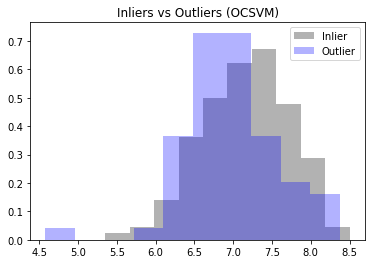

AU ROC: 0.595
AU PR: 0.125
##########################################


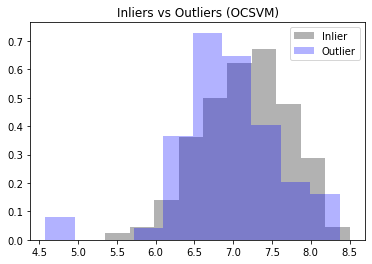

AU ROC: 0.591
AU PR: 0.141
##########################################


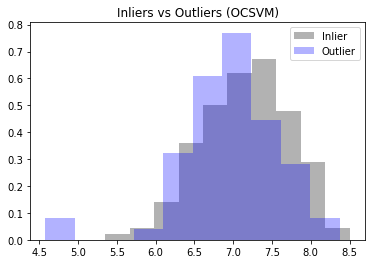

AU ROC: 0.574
AU PR: 0.134
##########################################


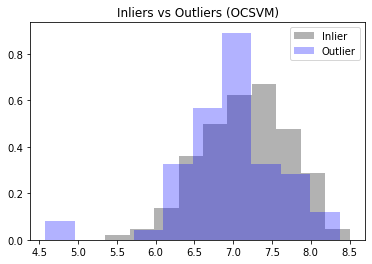

AU ROC: 0.575
AU PR: 0.136
##########################################


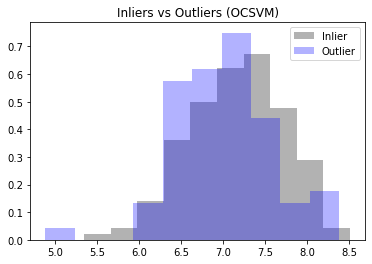

AU ROC: 0.575
AU PR: 0.118
##########################################


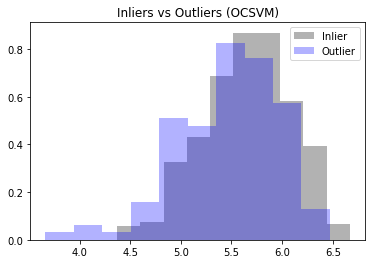

AU ROC: 0.593
AU PR: 0.289
##########################################


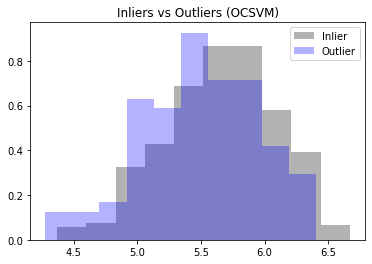

AU ROC: 0.593
AU PR: 0.264
##########################################


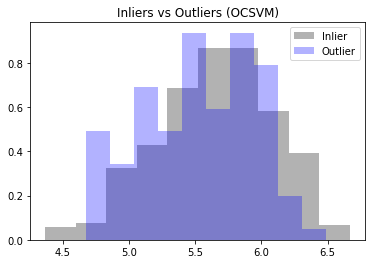

AU ROC: 0.574
AU PR: 0.244
##########################################


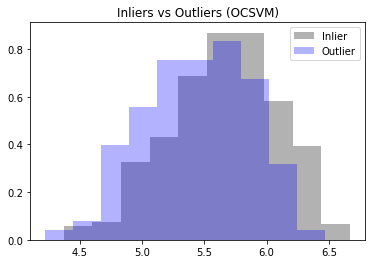

AU ROC: 0.627
AU PR: 0.276
##########################################


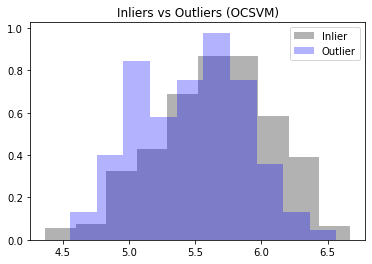

AU ROC: 0.616
AU PR: 0.263
##########################################


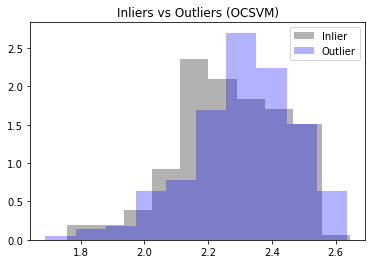

AU ROC: 0.419
AU PR: 0.521
##########################################


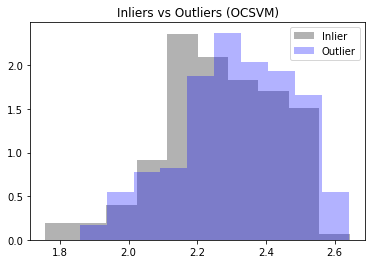

AU ROC: 0.413
AU PR: 0.520
##########################################


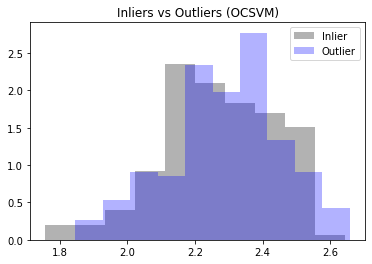

AU ROC: 0.457
AU PR: 0.541
##########################################


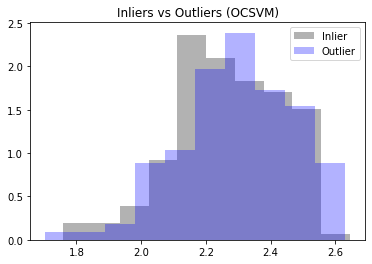

AU ROC: 0.448
AU PR: 0.544
##########################################


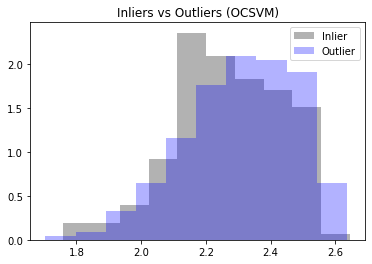

AU ROC: 0.423
AU PR: 0.531
##########################################


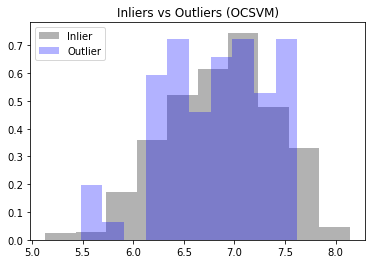

AU ROC: 0.525
AU PR: 0.119
##########################################


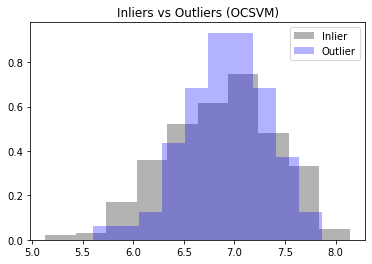

AU ROC: 0.478
AU PR: 0.099
##########################################


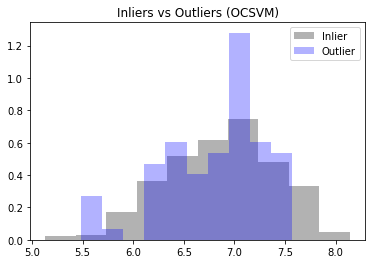

AU ROC: 0.525
AU PR: 0.122
##########################################


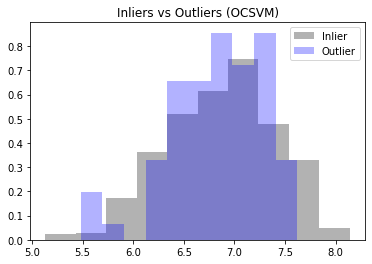

AU ROC: 0.519
AU PR: 0.114
##########################################


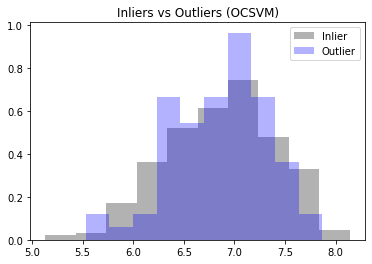

AU ROC: 0.506
AU PR: 0.109
##########################################


In [5]:
hierClass = 'Transient'
outliers = ['SLSN',
            'SNII',
            'SNIa',
            'SNIbc']

for outlier in outliers:
    for run in range(5):
        directory = './experiments/OCSVM_{}_{}_run{}'.format(hierClass, outlier, run)
        if not os.path.exists(directory):
            os.makedirs(directory)
        plots_dir = '{}/plots'.format(directory)
        if not os.path.exists(plots_dir):
            os.makedirs(plots_dir)
        
        train_features, test_features, test_labels = get_data(hierClass, outlier)
        model = train(train_features, directory)
        test(model, test_features, test_labels, directory)

## Stochastic Experiments

GP_DRW_tau_1
Pvar_1


/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


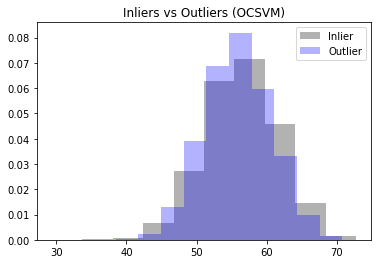

AU ROC: 0.531
AU PR: 0.144
##########################################
GP_DRW_tau_1


/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


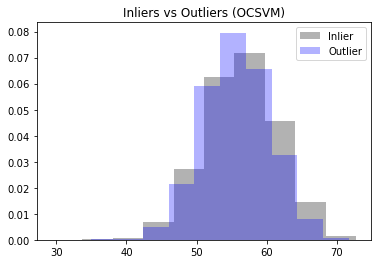

AU ROC: 0.539
AU PR: 0.149
##########################################
GP_DRW_tau_1


/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


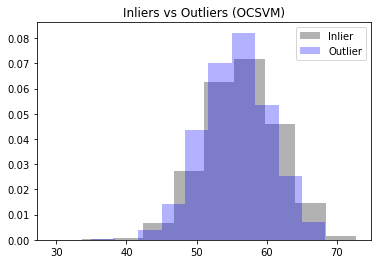

AU ROC: 0.541
AU PR: 0.148
##########################################
GP_DRW_tau_1


/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


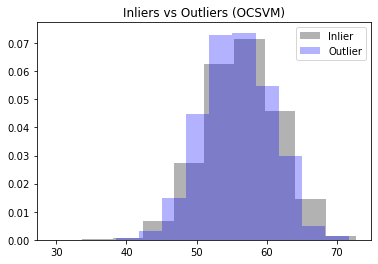

AU ROC: 0.538
AU PR: 0.148
##########################################
GP_DRW_tau_1


/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


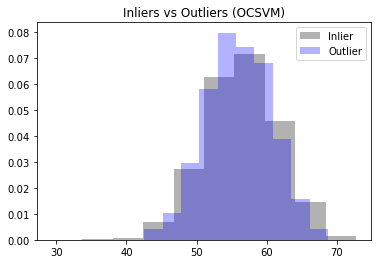

AU ROC: 0.523
AU PR: 0.140
##########################################
Pvar_1


/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


GP_DRW_tau_1


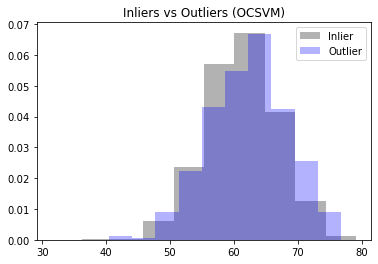

AU ROC: 0.444
AU PR: 0.094
##########################################
Pvar_1


/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


GP_DRW_tau_1


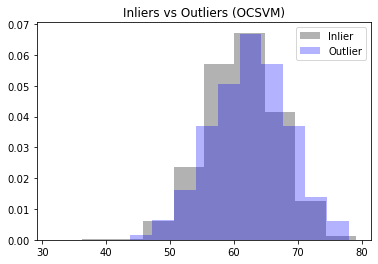

AU ROC: 0.438
AU PR: 0.092
##########################################
Pvar_1


/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


GP_DRW_tau_1


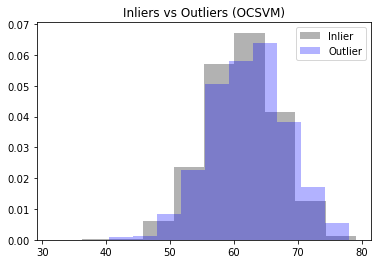

AU ROC: 0.448
AU PR: 0.094
##########################################
Pvar_1


/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


GP_DRW_tau_1


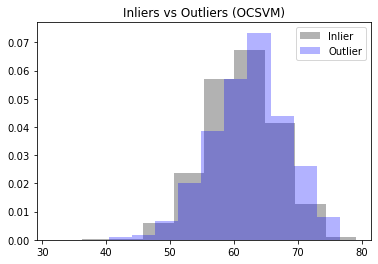

AU ROC: 0.431
AU PR: 0.091
##########################################
Pvar_1


/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


GP_DRW_tau_1


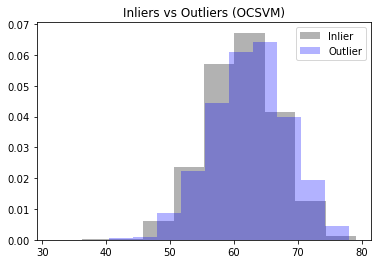

AU ROC: 0.434
AU PR: 0.090
##########################################
Pvar_1


/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


GP_DRW_tau_1


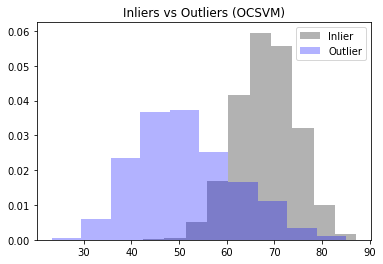

AU ROC: 0.909
AU PR: 0.776
##########################################
Pvar_1


/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


GP_DRW_tau_1


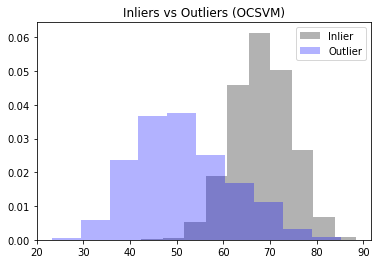

AU ROC: 0.908
AU PR: 0.775
##########################################
Pvar_1


/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


GP_DRW_tau_1


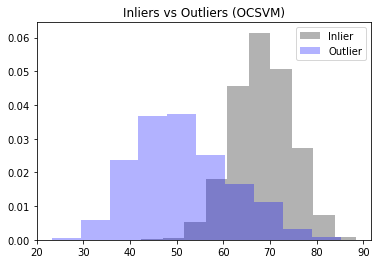

AU ROC: 0.909
AU PR: 0.778
##########################################
Pvar_1


/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


GP_DRW_tau_1


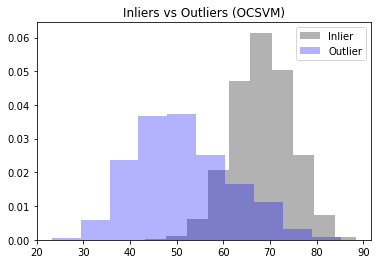

AU ROC: 0.909
AU PR: 0.778
##########################################
Pvar_1


/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


GP_DRW_tau_1


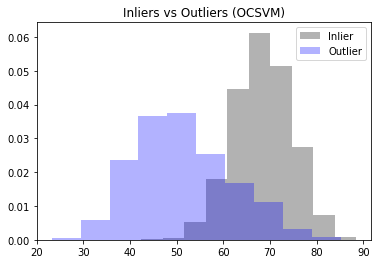

AU ROC: 0.910
AU PR: 0.776
##########################################
Pvar_1
GP_DRW_tau_1


/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


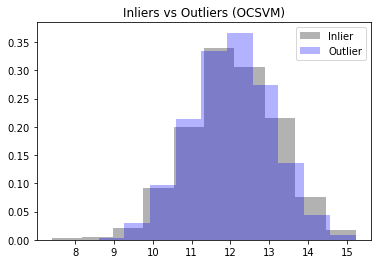

AU ROC: 0.504
AU PR: 0.671
##########################################
Pvar_1
GP_DRW_tau_1


/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


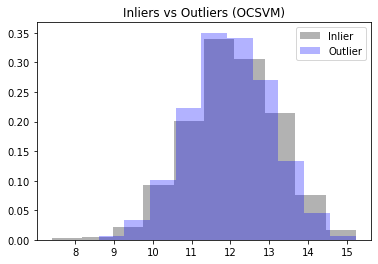

AU ROC: 0.517
AU PR: 0.681
##########################################
Pvar_1
GP_DRW_tau_1


/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


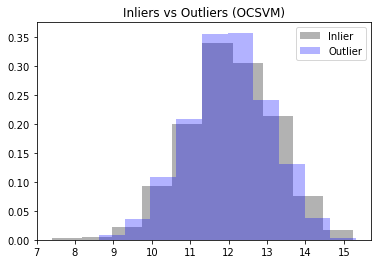

AU ROC: 0.511
AU PR: 0.678
##########################################
Pvar_1
GP_DRW_tau_1


/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


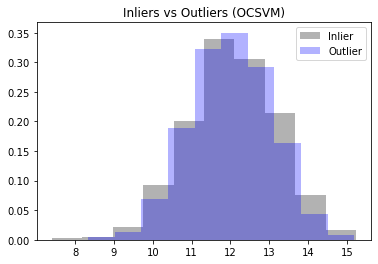

AU ROC: 0.511
AU PR: 0.676
##########################################
Pvar_1
GP_DRW_tau_1


/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


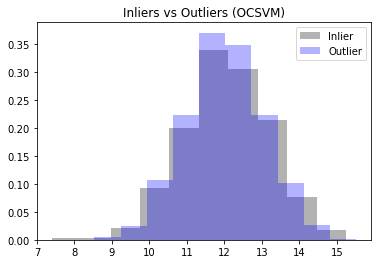

AU ROC: 0.514
AU PR: 0.677
##########################################
Pvar_1


/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


GP_DRW_tau_1


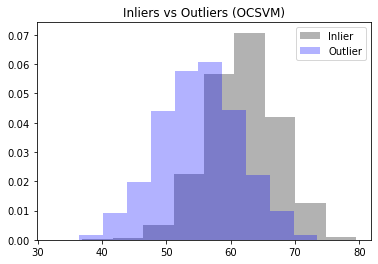

AU ROC: 0.789
AU PR: 0.392
##########################################
Pvar_1


/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


GP_DRW_tau_1


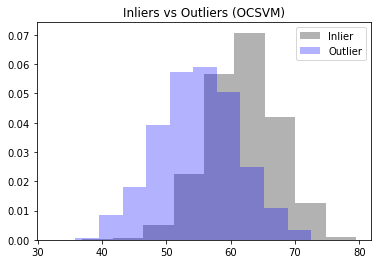

AU ROC: 0.797
AU PR: 0.413
##########################################
Pvar_1


/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


GP_DRW_tau_1


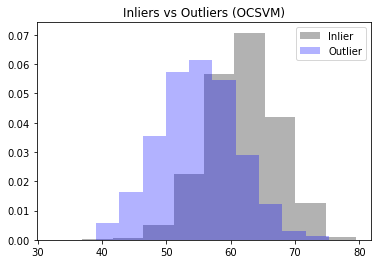

AU ROC: 0.799
AU PR: 0.406
##########################################
Pvar_1


/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


GP_DRW_tau_1


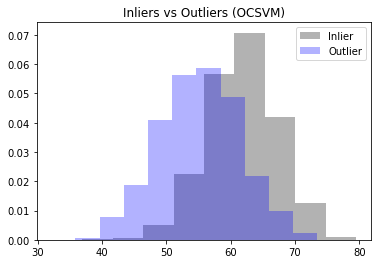

AU ROC: 0.790
AU PR: 0.398
##########################################
Pvar_1


/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


GP_DRW_tau_1


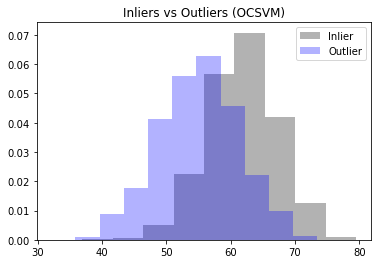

AU ROC: 0.793
AU PR: 0.399
##########################################


In [6]:
hierClass = 'Stochastic'
outliers = ['AGN',
            'Blazar',
            'CV/Nova',
            'QSO',
            'YSO']

for outlier in outliers:
    for run in range(5):
        directory = './experiments/OCSVM_{}_{}_run{}'.format(hierClass, outlier, run)
        if not os.path.exists(directory):
            os.makedirs(directory)
        plots_dir = '{}/plots'.format(directory)
        if not os.path.exists(plots_dir):
            os.makedirs(plots_dir)
        
        train_features, test_features, test_labels = get_data(hierClass, outlier)
        model = train(train_features, directory)
        test(model, test_features, test_labels, directory)

## Periodic Experiments

GP_DRW_tau_2


/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


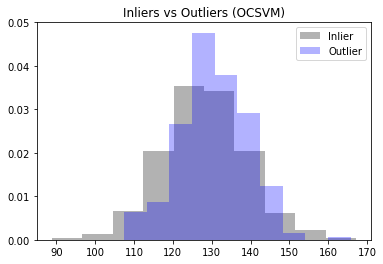

AU ROC: 0.425
AU PR: 0.080
##########################################
GP_DRW_tau_2


/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


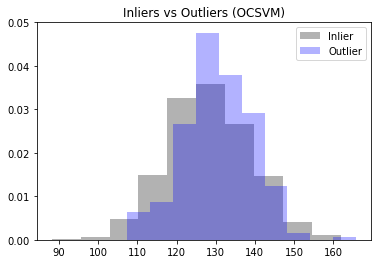

AU ROC: 0.430
AU PR: 0.080
##########################################
GP_DRW_tau_2


/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


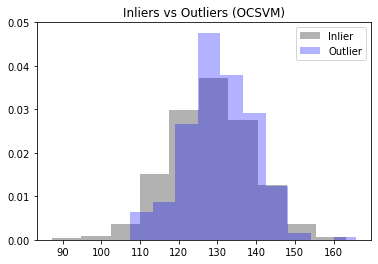

AU ROC: 0.438
AU PR: 0.081
##########################################
GP_DRW_tau_2


/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


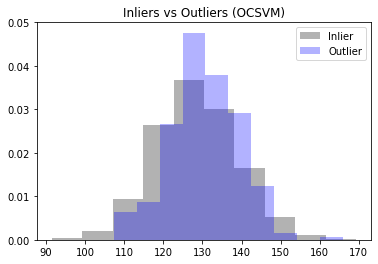

AU ROC: 0.434
AU PR: 0.081
##########################################
GP_DRW_tau_2


/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


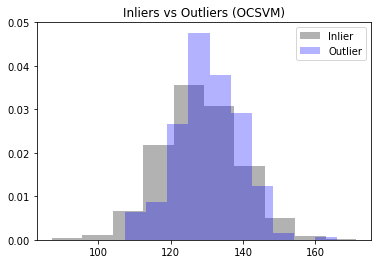

AU ROC: 0.427
AU PR: 0.080
##########################################
GP_DRW_tau_2


/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


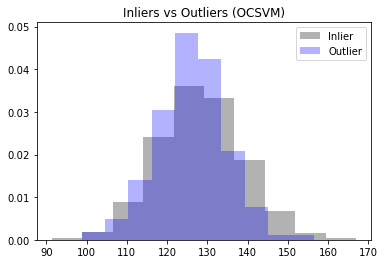

AU ROC: 0.562
AU PR: 0.110
##########################################
GP_DRW_tau_2


/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


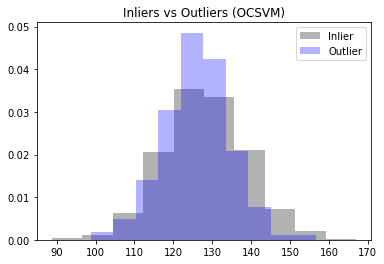

AU ROC: 0.561
AU PR: 0.110
##########################################
GP_DRW_tau_2


/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


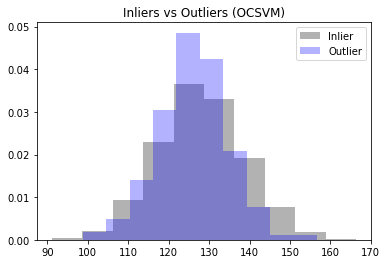

AU ROC: 0.555
AU PR: 0.107
##########################################
GP_DRW_tau_2


/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


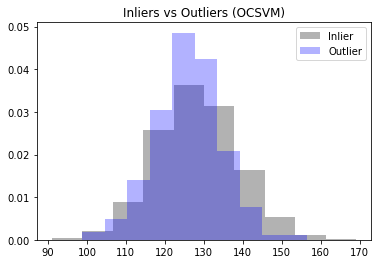

AU ROC: 0.563
AU PR: 0.110
##########################################
GP_DRW_tau_2


/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


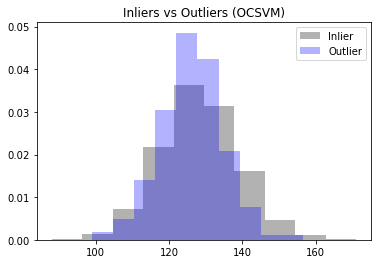

AU ROC: 0.562
AU PR: 0.109
##########################################
GP_DRW_tau_2


/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


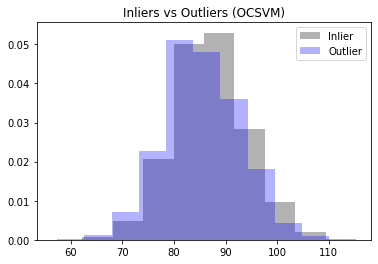

AU ROC: 0.561
AU PR: 0.316
##########################################
GP_DRW_tau_2


/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


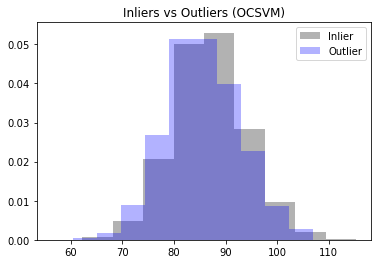

AU ROC: 0.553
AU PR: 0.305
##########################################
GP_DRW_tau_2


/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


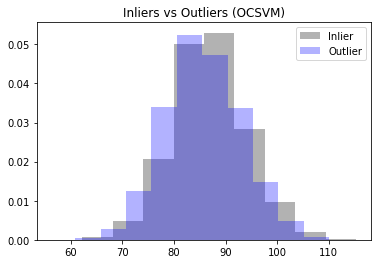

AU ROC: 0.544
AU PR: 0.301
##########################################
GP_DRW_tau_2


/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


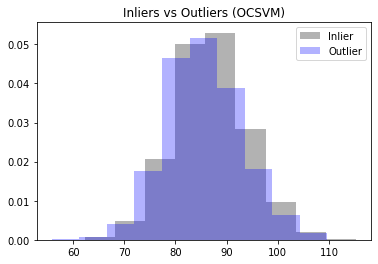

AU ROC: 0.560
AU PR: 0.312
##########################################
GP_DRW_tau_2


/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


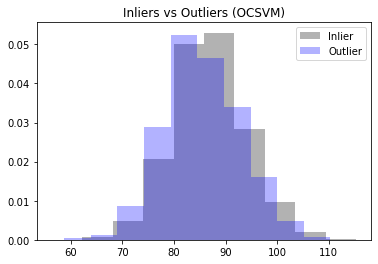

AU ROC: 0.557
AU PR: 0.313
##########################################
GP_DRW_tau_2


/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


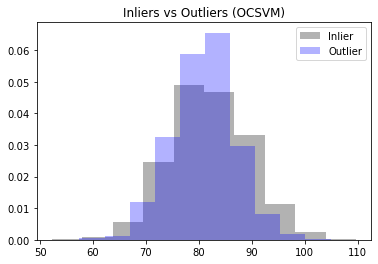

AU ROC: 0.541
AU PR: 0.282
##########################################


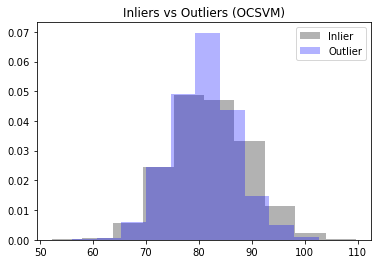

AU ROC: 0.537
AU PR: 0.279
##########################################


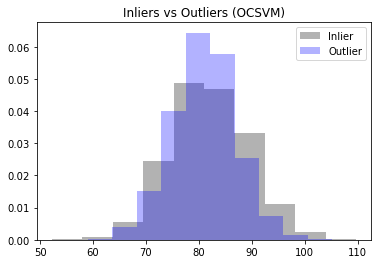

AU ROC: 0.540
AU PR: 0.282
##########################################


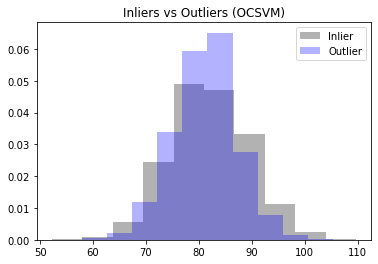

AU ROC: 0.531
AU PR: 0.277
##########################################
GP_DRW_tau_2


/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


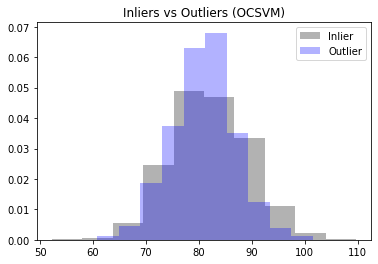

AU ROC: 0.543
AU PR: 0.283
##########################################
GP_DRW_tau_2


/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


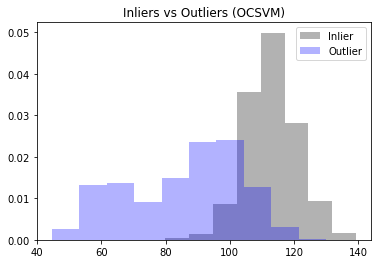

AU ROC: 0.941
AU PR: 0.885
##########################################
GP_DRW_tau_2


/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


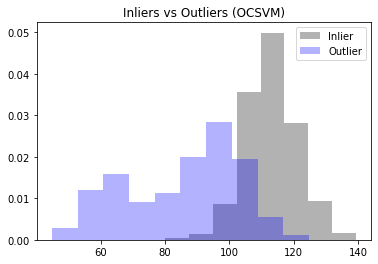

AU ROC: 0.946
AU PR: 0.890
##########################################
GP_DRW_tau_2


/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


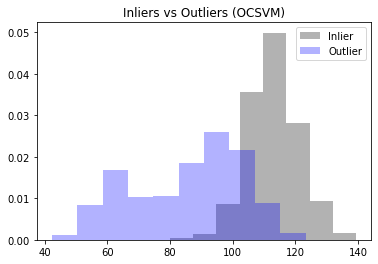

AU ROC: 0.943
AU PR: 0.886
##########################################
GP_DRW_tau_2


/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


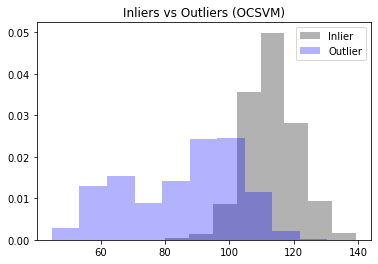

AU ROC: 0.946
AU PR: 0.890
##########################################
GP_DRW_tau_2


/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


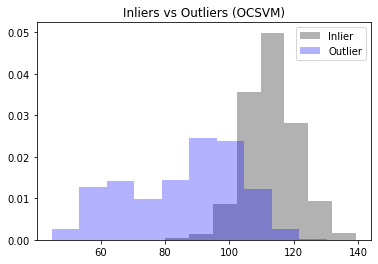

AU ROC: 0.942
AU PR: 0.886
##########################################


In [7]:
hierClass = 'Periodic'
outliers = ['CEP',
            'DSCT',
            'E',
            'RRL',
            'LPV']


for outlier in outliers:
    for run in range(5):
        directory = './experiments/OCSVM_{}_{}_run{}'.format(hierClass, outlier, run)
        if not os.path.exists(directory):
            os.makedirs(directory)
        plots_dir = '{}/plots'.format(directory)
        if not os.path.exists(plots_dir):
            os.makedirs(plots_dir)
        
        train_features, test_features, test_labels = get_data(hierClass, outlier)
        model = train(train_features, directory)
        test(model, test_features, test_labels, directory)